In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import classification_report
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from wordcloud import wordcloud

/usr/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/lib/python2.7/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
filename='X_train'
infile = open(filename,'rb')
X_train=pickle.load(infile)
infile.close()

filename='y_train'
infile = open(filename,'rb')
y_tr=pickle.load(infile)
infile.close()

filename='X_test'
infile = open(filename,'rb')
X_test=pickle.load(infile)
infile.close()

filename='y_test'
infile = open(filename,'rb')
y_test=pickle.load(infile)
infile.close()

In [3]:
#Unpickling
import pickle

infile = open('count_vect_BOW','rb')
count_vect=pickle.load(infile)
infile.close()

infile = open('Train_BOW_Std','rb')
X_train_Bow_standarized_data=pickle.load(infile)
infile.close()

infile = open('Test_BOW_Std','rb')
X_test_BOW_standarized_data=pickle.load(infile)
infile.close()

infile = open('tf_idf_vect_TF-IDF','rb')
tf_idf_vect = pickle.load(infile)
infile.close()

infile = open('Train_TFIDF_Std','rb')
X_train_tfidf_standarized_data=pickle.load(infile)
infile.close()

infile = open('Test_TFIDF_Std','rb')
X_test_tfidf_standarized_data=pickle.load(infile)
infile.close()

infile = open('Train_AvgW2V_std','rb')
X_train_AvgW2V_standarized_data=pickle.load(infile)
infile.close()


infile = open('Test_AvgW2V_std','rb')
X_test_AvgW2V_standarized_data=pickle.load(infile)
infile.close()

infile = open('TFIDF_W2V_Train_standarized_data','rb')
X_train_TFIDF_W2V_standarized_data=pickle.load(infile)
infile.close()


In [4]:
infile = open('TFIDF_W2V_Test_standarized_data','rb')
X_test_TFIDF_W2V_standarized_data=pickle.load(infile)
infile.close()

# GridSearch

In [5]:
def RF_GRIDSEARCH(X_train,y_train):
    tuned_parameters = [{ "n_estimators": range(100,1001,100),
                         "max_depth" : range(1,31,5)
                    }]  
    rf=RandomForestClassifier(class_weight = "balanced",n_jobs=-1)
    model= GridSearchCV(rf,tuned_parameters, scoring = 'f1', cv=5,n_jobs=-1)
    model.fit(X_train, y_train)
    best_estimator= model.best_estimator_
    best_params = model.best_params_
    
    return best_estimator,best_params


# Training_Testing Errors 

In [6]:
def Train_Test_Error(n_estimators,max_depth,X_train,y_train,X_test,y_test):
    rf=RandomForestClassifier(n_jobs=-1,class_weight = "balanced",max_depth=max_depth,n_estimators=n_estimators)
    rf_model = rf.fit(X_train, y_train)

    #Training Error
    y_pred_tr = rf_model.predict(X_train)
    acc_tr = accuracy_score(y_train, y_pred_tr)
    train_error = 1-acc_tr
    print('\n Train error is : {}'.format(train_error))

    #Test Error
    y_pred_ts = rf_model.predict(X_test)
    acc_ts = accuracy_score(y_test, y_pred_ts)
    test_error = 1-acc_ts
    print('\n Test error is : {}'.format(test_error))
    
    return train_error,test_error,y_pred_ts,rf_model

# CV_Error_Plot

In [7]:
def CV_Error_Plot(n_estimators,max_depth,X_Train,y_Train):
    n_estimators=range(100,1001,100)

    # empty list that will hold cv scores
    cv_scores = []

    for estimators in n_estimators:
        rf=RandomForestClassifier(n_jobs=-1,class_weight = "balanced",max_depth=max_depth,min_samples_split=10,n_estimators=estimators)
        scores = cross_val_score(rf, X_Train, y_Train, cv=3, scoring='accuracy',n_jobs=-1)
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_estimators = n_estimators[MSE.index(min(MSE))]
    print('\nThe optimal alpha is : {}'.format(optimal_estimators))

  
    plt.plot(n_estimators, MSE)

    for xy in zip(n_estimators, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('No.of Base Models')
    plt.ylabel('Misclassification Error')
    plt.show()
    print("the misclassification error for each n_estimators value is : ", np.round(MSE,3)) 
    return optimal_estimators

# Confusion Matrix

In [8]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# RF_BOW

Using GridSearch

In [11]:
best_estimator_bow,best_params_bow = RF_GRIDSEARCH(X_train_Bow_standarized_data,y_tr)
print best_estimator_bow
print best_params_bow 

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=26, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'n_estimators': 900, 'max_depth': 26}


Errors using Grid Search

In [12]:
train_error_bow,test_error_bow,y_pred_ts_bow,model_bow=\
Train_Test_Error(best_params_bow["n_estimators"],best_params_bow["max_depth"],X_train_Bow_standarized_data,y_tr,X_test_BOW_standarized_data,y_test)


 Train error is : 0.0555645975066

 Test error is : 0.104439633892


Error Plot


The optimal alpha is : 900


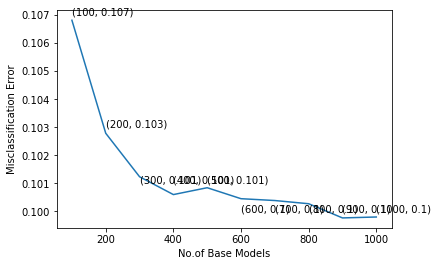

('the misclassification error for each n_estimators value is : ', array([0.107, 0.103, 0.101, 0.101, 0.101, 0.1  , 0.1  , 0.1  , 0.1  ,
       0.1  ]))


In [13]:
optimal_estimators_bow = CV_Error_Plot(best_params_bow["n_estimators"],best_params_bow["max_depth"],X_train_Bow_standarized_data,y_tr)


  CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.70      0.69      0.70      4557
          1       0.94      0.94      0.94     21774

avg / total       0.89      0.90      0.90     26331


  CONFUSION MATRIX
[[ 3148  1409]
 [ 1341 20433]]

  Plot of CONFUSION MATRIX


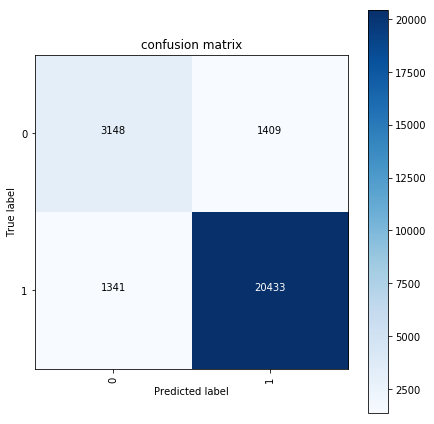

In [14]:
from sklearn.metrics import classification_report
#Evaluate precission,recall,f1-score
classification_report = classification_report(y_test, y_pred_ts_bow)
print "\n  CLASSIFICATION REPORT"
print classification_report

#determine Confusion matrix  and plotting
cm = confusion_matrix(y_test, y_pred_ts_bow)
print "\n  CONFUSION MATRIX"
print cm
print "\n  Plot of CONFUSION MATRIX"
plt.figure(figsize=(6,6))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['0','1'], normalize=False, title='confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [9]:
infile = open('model_bow_RF','rb')
model_bow = pickle.load(infile)
infile.close()

infile = open('model_tfidf_RF','rb')
model_tfidf=pickle.load(infile)
infile.close()

In [10]:
index_to_word = {v:k for k,v in count_vect.vocabulary_.items()}

In [ ]:
weights3=[(index_to_word[i],model_bow.feature_importances_[i]) for i in np.nonzero(model_bow.feature_importances_)[0]]
weights4=sorted(weights3,reverse=True,key=lambda x: x[1])
dict_words= dict()
for i in range(len(weights4)):
    dict_words[weights4[i][0]] = weights4[i][1] 
print ('Postive Words::',weights4[0:20])
print ('Negative Words::',weights4[-20:])

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=2000, 
                min_font_size = 10).generate_from_frequencies(dict_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# TFIDF

In [15]:
best_estimator_tfidf,best_params_tfidf = RF_GRIDSEARCH(X_train_tfidf_standarized_data,y_tr)
print best_estimator_tfidf
print best_params_tfidf

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=26, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'n_estimators': 800, 'max_depth': 26}


Using GridSearch

In [16]:
train_error_tfidf,test_error_tfid,y_pred_ts_tfid,model_tfidf=Train_Test_Error(best_params_tfidf["n_estimators"],best_params_tfidf["max_depth"],X_train_AvgW2V_standarized_data,y_tr,X_test_AvgW2V_standarized_data,y_test)


 Train error is : 0.000667295986459

 Test error is : 0.168850404466



The optimal alpha is : 800


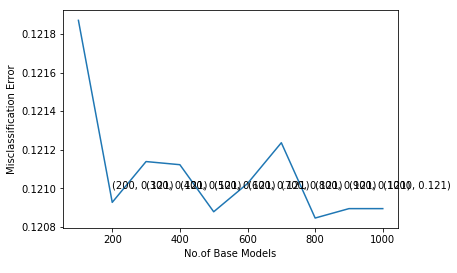

('the misclassification error for each n_estimators value is : ', array([0.122, 0.121, 0.121, 0.121, 0.121, 0.121, 0.121, 0.121, 0.121,
       0.121]))


In [17]:
optimal_estimators_tfidf = CV_Error_Plot(best_params_tfidf["n_estimators"],best_params_tfidf["max_depth"],X_train_AvgW2V_standarized_data,y_tr)


  CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.79      0.03      0.06      4557
          1       0.83      1.00      0.91     21774

avg / total       0.82      0.83      0.76     26331


  CONFUSION MATRIX
[[  151  4406]
 [   40 21734]]

  Plot of CONFUSION MATRIX


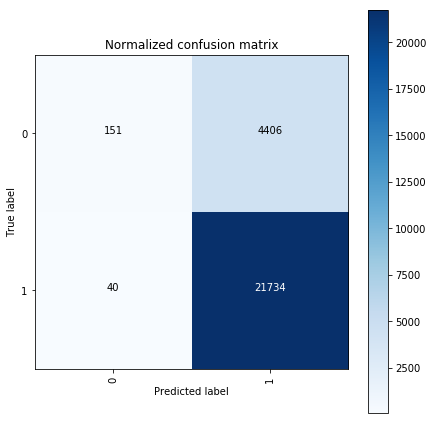

In [18]:
from sklearn.metrics import classification_report
#Evaluate precission,recall,f1-score
classification_report = classification_report(y_test, y_pred_ts_tfid)
print "\n  CLASSIFICATION REPORT"
print classification_report

#determine Confusion matrix  and plotting
cm = confusion_matrix(y_test, y_pred_ts_tfid)
print "\n  CONFUSION MATRIX"
print cm
print "\n  Plot of CONFUSION MATRIX"
plt.figure(figsize=(6,6))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['0','1'], normalize=False, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [ ]:
index_to_word = {v:k for k,v in tf_idf_vect.vocabulary_.items()}

weights3=[(index_to_word[i],model_tfidf.feature_importances_[i]) for i in np.nonzero(model_tfidf.feature_importances_)[0]]
weights4=sorted(weights3,reverse=True,key=lambda x: x[1])
dict_words= dict()
for i in range(len(weights4)):
    dict_words[weights4[i][0]] = weights4[i][1] 

print ('Postive Words::',weights4[0:20])
print ('Negative Words::',weights4[-20:])

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                max_words=2000, 
                min_font_size = 10).generate_from_frequencies(dict_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# RF-AVGW2V

GRIDSEEARCH

In [18]:
best_estimator_avgw2v,best_params_avgw2v = RF_GRIDSEARCH(X_train_AvgW2V_standarized_data,y_tr)
print best_estimator_avgw2v
print best_params_avgw2v

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'n_estimators': 600, 'max_depth': 16}


Errors--Gridsearch

In [19]:
train_error_avgw2v,test_error_avgw2v,y_pred_ts_avgw2v,model_avgw2v=Train_Test_Error(best_params_avgw2v["n_estimators"],best_params_avgw2v["max_depth"],X_train_AvgW2V_standarized_data,y_tr,X_test_AvgW2V_standarized_data,y_test)


 Train error is : 0.0150385729631

 Test error is : 0.162356158141


CV-ErrorPlot


The optimal alpha is : 300


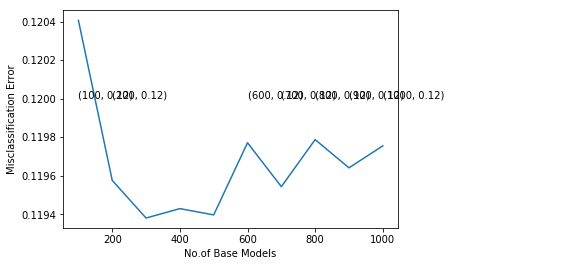

('the misclassification error for each n_estimators value is : ', array([0.12 , 0.12 , 0.119, 0.119, 0.119, 0.12 , 0.12 , 0.12 , 0.12 ,
       0.12 ]))


In [20]:
optimal_estimators_AvgW2V = CV_Error_Plot(best_params_avgw2v["n_estimators"],best_params_avgw2v["max_depth"],X_train_AvgW2V_standarized_data,y_tr)

Confusion Matrix


  CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.66      0.13      0.21      4557
          1       0.84      0.99      0.91     21774

avg / total       0.81      0.84      0.79     26331


  CONFUSION MATRIX
[[  582  3975]
 [  300 21474]]

  Plot of CONFUSION MATRIX


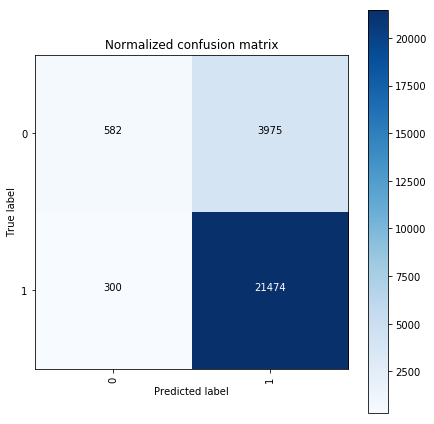

In [23]:
from sklearn.metrics import classification_report
#Evaluate precission,recall,f1-score
classification_report = classification_report(y_test, y_pred_ts_avgw2v)
print "\n  CLASSIFICATION REPORT"
print classification_report

#determine Confusion matrix  and plotting
cm = confusion_matrix(y_test, y_pred_ts_avgw2v)
print "\n  CONFUSION MATRIX"
print cm
print "\n  Plot of CONFUSION MATRIX"
plt.figure(figsize=(6,6))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['0','1'], normalize=False, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

# RF- tfidfw2v

GridSearch

In [25]:
best_estimator_TFIDF_W2V,best_params_TFIDF_W2V = RF_GRIDSEARCH(X_train_TFIDF_W2V_standarized_data,y_tr)
print best_estimator_TFIDF_W2V
print best_params_TFIDF_W2V

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'n_estimators': 900, 'max_depth': 16}


Errors- Grid search

In [26]:
train_error_TFIDF_W2V,test_error_TFIDF_W2V,y_pred_ts_TFIDF_W2V,model_TFIDF_W2V=\
Train_Test_Error(best_params_TFIDF_W2V["n_estimators"],best_params_TFIDF_W2V["max_depth"],X_train_TFIDF_W2V_standarized_data,y_tr,X_test_TFIDF_W2V_standarized_data,y_test)


 Train error is : 0.0124833176003

 Test error is : 0.164255060575


CV-Error Plot


The optimal alpha is : 800


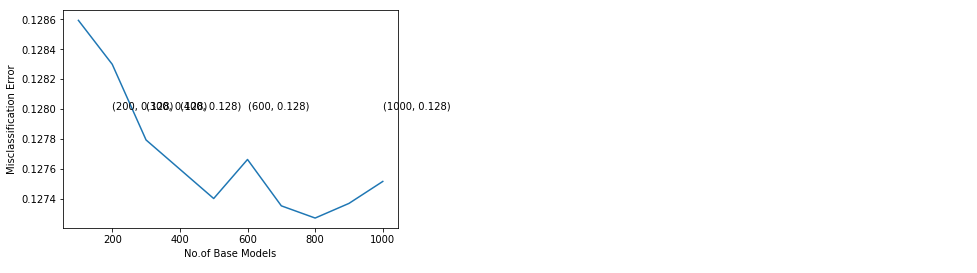

('the misclassification error for each n_estimators value is : ', array([0.129, 0.128, 0.128, 0.128, 0.127, 0.128, 0.127, 0.127, 0.127,
       0.128]))


In [27]:
optimal_estimators_tfidf = \
CV_Error_Plot(best_params_TFIDF_W2V["n_estimators"],best_params_TFIDF_W2V["max_depth"],X_train_TFIDF_W2V_standarized_data,y_tr)

Confusion Matrix


  CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.67      0.10      0.18      4557
          1       0.84      0.99      0.91     21774

avg / total       0.81      0.84      0.78     26331


  CONFUSION MATRIX
[[  465  4092]
 [  233 21541]]

  Plot of CONFUSION MATRIX


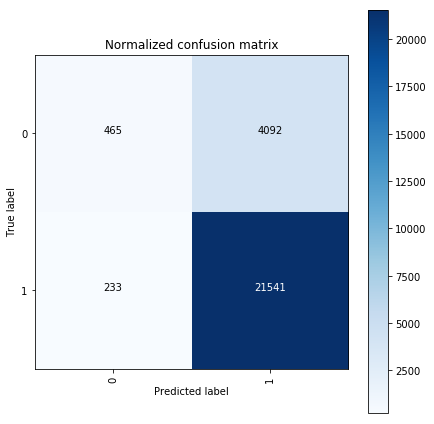

In [28]:
from sklearn.metrics import classification_report
#Evaluate precission,recall,f1-score
classification_report = classification_report(y_test, y_pred_ts_TFIDF_W2V)
print "\n  CLASSIFICATION REPORT"
print classification_report

#determine Confusion matrix  and plotting
cm = confusion_matrix(y_test, y_pred_ts_TFIDF_W2V)
print "\n  CONFUSION MATRIX"
print cm
print "\n  Plot of CONFUSION MATRIX"
plt.figure(figsize=(6,6))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['0','1'], normalize=False, title='Normalized confusion matrix', cmap = plt.cm.Blues)
plt.show()

# Summary

In [21]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorization Model","Seach Methood","n_estimators","max_depth", "Training Error","Test Error"]

x.add_row(["Bow", "GRID", best_params_bow["n_estimators"],best_params_bow["max_depth"], round(train_error_bow*100,2),round(test_error_bow*100,2)])

x.add_row(["TFIDF", "GRID", best_params_tfidf["n_estimators"],best_params_tfidf["max_depth"],round(train_error_tfidf*100,2),round(test_error_tfid*100,2)])

x.add_row(["AvgW2V", "GRID", 600,16,1.5,16.23])

x.add_row(["TFIDF-W2V", "GRID", 900,16,1.42,16.24])

print(x)

+---------------------+---------------+--------------+-----------+----------------+------------+
| Vectorization Model | Seach Methood | n_estimators | max_depth | Training Error | Test Error |
+---------------------+---------------+--------------+-----------+----------------+------------+
|         Bow         |      GRID     |     900      |     26    |      5.56      |   10.44    |
|        TFIDF        |      GRID     |     800      |     26    |      0.07      |   16.89    |
|        AvgW2V       |      GRID     |     600      |     16    |      1.5       |   16.23    |
|      TFIDF-W2V      |      GRID     |     900      |     16    |      1.42      |   16.24    |
+---------------------+---------------+--------------+-----------+----------------+------------+
